In [1]:
# Import modules
import tensorflow as tf
import keras as K
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
import tensorflow_hub as hub
from keras.models import load_model

import pandas as pd
import numpy as np
import PIL
import logging
import os

import zipfile
import shutil

from datetime import datetime

# for figures
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#import seaborn as sns

# for the Grad-CAMs
from IPython.display import Image, display
import matplotlib.cm as cm

# Working Directory on A4 Computer (GoPro and V2 data are on the A4 Computer)
files = os.listdir()

os.chdir("/home/scott/Dropbox/IMAGINE Project/MSSI_Project/")
cwd = os.getcwd()
print("Current working directory:", cwd)

# This code allows GPU memory allocation to grow as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

2024-07-23 16:50:48.608627: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-23 16:50:48.608666: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-23 16:50:48.608702: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-23 16:50:48.617872: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-23 16:50:49.719737: W tensorflow/compiler/

Current working directory: /home/scott/Dropbox/IMAGINE Project/MSSI_Project


In [2]:
#  Prints the Tensorflow, Keras versions, and number of GPUs
print(tf.__version__)
print(K.__version__)
# print("TensorFlow Hub version:", hub.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
2.14.0
Num GPUs Available:  4


In [3]:
from platform import python_version

print(python_version())
print("cuDNN version:", tf.sysconfig.get_build_info()['cudnn_version'])

3.9.19
cuDNN version: 8


In [15]:
!nvidia-smi

Tue Jul 23 16:53:12 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA TITAN Xp     On   | 00000000:05:00.0 Off |                  N/A |
| 23%   34C    P8    10W / 250W |     89MiB / 12288MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA TITAN Xp     On   | 00000000:06:00.0 Off |                  N/A |
| 23%   

In [5]:
# Ensure there's enough space
def check_disk_space():
    total, used, free = shutil.disk_usage("/")
    print(f"Total: {total // (2**30)} GiB")
    print(f"Used: {used // (2**30)} GiB")
    print(f"Free: {free // (2**30)} GiB")
    return free

free_space = check_disk_space()
if free_space < (1 * 2**30):  # Check if free space is less than 1 GiB
    print("Warning: Low disk space. Consider freeing up some space.")

Total: 3666 GiB
Used: 996 GiB
Free: 2484 GiB


In [6]:
#This compiled file incorporate all existing data with GoPro in training set only

metadata = pd.read_csv("compiled data/metadata_goproUFP_V2_V3_04252024.csv", low_memory=False)
# Train: 100% GoPro + 80% Imagine V2 and V3
# Val: 10% Imagine V2 and V3
# Tst: 10% Imagine V2 and V3

In [9]:
# Check for NaNs in the entire DataFrame
# print(metadata.isna().sum())

In [16]:
# Ensure no NaNs in data
# assert not np.any(np.isnan(metadata['ln_ufp_num_10s_ma_image_label_raw']))
# assert not np.any(np.isnan(metadata[image_path]))

In [19]:
# print(metadata['image_path'][200000])

In [7]:
# Look at data
metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,image_extension,audio_extension,image_name,audio_name,pair_pm25,set_V3ext,set,vsby_nm
0,2019-04-23T10:20:27Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.744668,9.744668,3.098740,3.098740,4.319752,4.319752,17063.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
1,2019-04-23T10:20:28Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.710145,9.710145,3.119276,3.119276,4.309322,4.309322,16484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
2,2019-04-23T10:20:29Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.683153,9.683153,3.144583,3.144583,4.327702,4.327702,16045.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
3,2019-04-23T10:20:30Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.583558,9.583558,3.167583,3.167583,4.320018,4.320018,14524.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
4,2019-04-23T10:20:31Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.509259,9.509259,3.184698,3.184698,4.303119,4.303119,13484.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
5,2019-04-23T10:20:32Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.479069,9.479069,3.197448,3.197448,4.277360,4.277360,13083.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
6,2019-04-23T10:20:33Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.422544,9.422544,3.211650,3.211650,4.273606,4.273606,12364.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
7,2019-04-23T10:20:34Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.399638,9.399638,3.223664,3.223664,4.260000,4.260000,12084.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
8,2019-04-23T10:20:35Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.403107,9.403107,3.235536,3.235536,4.227709,4.227709,12126.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0
9,2019-04-23T10:20:36Z,archived files no longer used/GoPro Model/data...,archived files no longer used/GoPro Model/data...,9.406976,9.406976,3.241029,3.241029,4.200804,4.200804,12173.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,trn,trn,30.0


In [8]:
# How much data in trn, val, tst sets for metadata_random_split

metadata.set.value_counts()

set
trn    345680
val     22407
tst     22223
Name: count, dtype: int64

In [ ]:
# Sanity check: compare total image and audio data fields

In [9]:
#Select input file type (this tells python where to look for the file paths)
file = input("What input are you using: images, or spectrograms? ")

if file == 'images':
    file = 'image_path'
else:
  if file == 'spectrograms':
      file = 'audio_path'
  else:
    print('!!!TYPO in input_data name')

What input are you using: images, or spectrograms?  images


In [10]:
# Define Initial Learning Rate
initial_learning_rate = 1e-4
meta_data_name = "gp_v2_v3_Training_Only"

In [11]:
# Model architectures
architecture = input("What architecture do you want to use: ConvNeXT_linear_AdamW_Base, ConvNeXT_linear_AdamW_Large, ConvNeXt_Tiny_linear_AdamW, ResNet50_AdamW_Nadam, ConvNeXT_linear_AdamW_Base_L2_Dropout ?")
from tensorflow.keras import backend as Kb

# Define global variables for dropout rate and L2 regularization strength
global_dropout_rate = 0.5
global_l2_regularization = 1e-4

def custom_mse(y_true, y_pred):
    loss = Kb.mean(Kb.square(y_true - y_pred), axis=-1)
    tf.print("y_true:", y_true)
    tf.print("y_pred:", y_pred)
    tf.print("loss:", loss)
    return loss
    
if architecture == 'ConvNeXT_linear_AdamW_Base':
    architecture_preprocessing = K.applications.convnext.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtBase(model_name="convnext_base",include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output) 
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model

elif architecture == 'ConvNeXT_linear_AdamW_Base_L2_Dropout':
    # Preprocessing function
    architecture_preprocessing = K.applications.convnext.preprocess_input

    # Define the model function
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
    
        # Load ConvNeXt base model
        conv_base = K.applications.ConvNeXtBase(
            model_name="convnext_base",
            include_top=False,
            weights="imagenet",
            input_tensor=model_input
        )
    
        # Add dropout and regularization
        x = K.layers.GlobalAveragePooling2D()(conv_base.output)
        x = K.layers.Dropout(global_dropout_rate)(x)  # Apply dropout with 30% rate
        x = K.layers.Dense(units=256, activation='relu', kernel_regularizer=K.regularizers.l2(global_l2_regularization))(x)  # Intermediate Dense layer with ReLU and L2 regularization
        x = K.layers.Dropout(global_dropout_rate)(x)  # Apply dropout with 30% rate
        model_output = K.layers.Dense(units=1, activation='linear', kernel_regularizer=K.regularizers.l2(global_l2_regularization))(x)  # Output layer with linear activation for regression
    
        # Create and compile the model
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
    
        return model

elif architecture == 'ConvNeXT_linear_AdamW_Large':
    architecture_preprocessing = K.applications.convnext.preprocess_input
    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtLarge(include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=K.optimizers.AdamW(learning_rate=initial_learning_rate),
            loss='mse',
            metrics=['mae']
        )
        return model

elif architecture == 'ConvNeXt_Tiny_AdamW':
    architecture_preprocessing = K.applications.convnext.preprocess_input

    def get_compiled_model():
        model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
        conv_base = K.applications.ConvNeXtTiny(include_top=False, weights="imagenet", input_tensor=model_input)
        model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
        model_output = K.layers.Dense(units=1, activation='linear')(model_output)
    
        # Learning rate schedule
        initial_learning_rate = 1e-5
        lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
            initial_learning_rate=initial_learning_rate,
            decay_steps=10000,
            alpha=0.0
        )
        optimizer = K.optimizers.AdamW(learning_rate=lr_schedule, clipnorm=1.0)
        model = K.models.Model(inputs=model_input, outputs=model_output)
        model.compile(
            optimizer=optimizer,
            loss='mean_squared_error',
            metrics=['mae']
        )
        return model
                        
else:
    print('!!!TYPO in architecture name')

What architecture do you want to use: ConvNeXT_linear_AdamW_Base, ConvNeXT_linear_AdamW_Large, ConvNeXt_Tiny_linear_AdamW, ResNet50_AdamW_Nadam, ConvNeXT_linear_AdamW_Base_L2_Dropout ? ConvNeXT_linear_AdamW_Base_L2_Dropout


In [35]:
# Expt 1: Train on 5 sites, evaluate on 1

In [12]:
# How much data in each site
unique_values_list = metadata['site_id'].unique().tolist()
print(unique_values_list)

# Get the count of each unique value
site_id_counts = metadata['site_id'].value_counts(dropna=False)

# Print the counts
print("Counts for each site ID:")
print(site_id_counts)

# Total count
print("Total Count:", site_id_counts.sum())

[nan, '1', '2', '3', '4', 'New_Sensor_1_Montreal_Atwater_August_2023', 'New_Sensor_1_Montreal_Jean_Talon_West_June_2023']
Counts for each site ID:
site_id
NaN                                                167163
4                                                   72476
3                                                   58919
2                                                   37500
1                                                   31019
New_Sensor_1_Montreal_Jean_Talon_West_June_2023     20956
New_Sensor_1_Montreal_Atwater_August_2023            2277
Name: count, dtype: int64
Total Count: 390310


In [13]:
# Define the sites for training, validation, and testing

validation_site = 'New_Sensor_1_Montreal_Jean_Talon_West_June_2023'
test_site = 'New_Sensor_1_Montreal_Atwater_August_2023'
# train_sites = 'nan'

# train sites = metadata - (test_sites) - (validation_sites)
train_sites = metadata['site_id'].unique().tolist()
train_sites.remove(test_site)
train_sites.remove(validation_site)

# train_sites.remove('1')
# train_sites.remove('2')
# train_sites.remove('3')
# train_sites.remove('4')


# Get the total count for each dataset
train_data_count = metadata[metadata['site_id'].isin(train_sites)].shape[0]
validation_data_count = metadata[metadata['site_id'] == validation_site].shape[0]
test_data_count = metadata[metadata['site_id'] == test_site].shape[0]

print('train_sites: ', train_sites)
print('validation_site: ', validation_site)
print('test_site: ', test_site)

print(f"Total training data count: {train_data_count}")
print(f"Total validation data count: {validation_data_count}")
print(f"Total test data count: {test_data_count}")

train_sites:  [nan, '1', '2', '3', '4']
validation_site:  New_Sensor_1_Montreal_Jean_Talon_West_June_2023
test_site:  New_Sensor_1_Montreal_Atwater_August_2023
Total training data count: 367077
Total validation data count: 20956
Total test data count: 2277


In [108]:
# Print a slice of the DataFrame to inspect
# print(metadata[['site_id', 'image_path']].head())
# print(metadata['site_id'].isin(train_sites))

In [14]:
# Select Exposure to be modelled
import os
import keras as K

cwd = os.getcwd()
print("Current working directory:", cwd)

def check_input_and_target_compatibility(target):
    if ((target == 'ln_noise_10s_ma_image_label_raw' or 
         target == 'ln_ufp_num_10s_ma_image_label_raw' or
         target == 'ln_ufp_size_10s_ma_image_label_raw') and
        file == 'audio_path'):
        print("!!! Input file not compatible with exposure !!!")
        return False
        
    elif ((target == 'ln_noise_10s_ma_spec_label_raw' or 
           target == 'ln_ufp_num_10s_ma_spec_label_raw' or
           target == 'ln_ufp_size_10s_ma_spec_label_raw') and
          file == 'image_path'):
        print("!!! Input file not compatible with exposure !!!")
        return False
        
    else:
        return True

# Get train and validate generators
def get_train_val_generator(target):
    # Making sure that wrong input is not fed into target
    if not check_input_and_target_compatibility(target):
        print("Please make sure `target` is compatible with `file_path`")
        return
        
    # Define the ImageDataGenerator with preprocessing function
    generator = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing, 
                                                         horizontal_flip=True,
                                                         vertical_flip=False)

    # Training generator - use all sites except the validation and test sites
    train_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['site_id'].isin(train_sites), [target, file]].reset_index(drop=True),  
                                                    x_col=file,  # file = image_path or audio_path
                                                    y_col=target,  # target = exposure to be modelled
                                                    class_mode='raw', 
                                                    target_size=(256, 256),  # all of our images will be resized to 256 x 256
                                                    color_mode='rgb', 
                                                    batch_size=64,
                                                    shuffle=True)

    # Validation generator - use only the validation site
    validate_generator = generator.flow_from_dataframe(dataframe=metadata.loc[metadata['site_id'] == validation_site, [target, file]].reset_index(drop=True),
                                                       x_col=file,
                                                       y_col=target,
                                                       class_mode='raw',
                                                       target_size=(256, 256),
                                                       color_mode='rgb',
                                                       batch_size=64,
                                                       shuffle=False)

    # Define callbacks
    # Log file name (Change this if running multiple experiments on same model)
    # csv_logger = K.callbacks.CSVLogger('./rishabh_model_files/logs/XGB_experiment_1/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.csv')    
    # Model file name (Change this if running multiple experiments on same model)
    # model_checkpoint = K.callbacks.ModelCheckpoint('./rishabh_model_files/models/XGB_experiment_1/'+target+','+architecture+','+file+','+meta_data_name+'_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.tf', monitor='val_loss', mode='auto', save_weights_only=False,save_best_only=True)
    csv_logger = K.callbacks.CSVLogger(f'./rishabh_model_files/logs/XGB_experiment_1/{target},{architecture},{file},{meta_data_name}_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_{global_dropout_rate}_l2_{global_l2_regularization}.csv')
    model_checkpoint = K.callbacks.ModelCheckpoint(
        f'./rishabh_model_files/models/XGB_experiment_1/{target},{architecture},{file},{meta_data_name}_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_{global_dropout_rate}_l2_{global_l2_regularization}.tf',
        monitor='val_loss',
        mode='auto',
        save_weights_only=False,
        save_best_only=True
    )
    reduce_lr_on_plateau = K.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, mode='auto', verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)

    return train_generator, validate_generator, [csv_logger, model_checkpoint, reduce_lr_on_plateau, early_stopping]

target = input("What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ?")                  

if target == 'ln_noise_10s_ma_image_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)

elif target == 'ln_noise_10s_ma_spec_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)
    
elif target == 'ln_ufp_num_10s_ma_image_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)

elif target == 'ln_ufp_num_10s_ma_spec_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)
    
elif target == 'ln_ufp_size_10s_ma_image_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)
    
elif target == 'ln_ufp_size_10s_ma_spec_label_raw':
    train_generator, validate_generator, callbacks = get_train_val_generator(target)
    
else:
    print('!!!TYPO in exposure name')


Current working directory: /home/scott/Dropbox/IMAGINE Project/MSSI_Project


What do you want to model: ln_noise_10s_ma_spec_label_raw, ln_noise_10s_ma_image_label_raw, ln_ufp_num_10s_ma_spec_label_raw, ln_ufp_num_10s_ma_image_label_raw, ln_ufp_size_10s_ma_image_label_raw, ln_ufp_size_10s_ma_spec_label_raw ? ln_noise_10s_ma_image_label_raw


Found 367077 validated image filenames.
Found 20956 validated image filenames.


In [23]:
# import matplotlib.pyplot as plt
# from keras.preprocessing.image import load_img

# # Assuming 'metadata' is your dataframe and 'file' is the column with image paths

# # Filter the dataframe for site_id = 1
# site_data = metadata[metadata['site_id'] == '4']  # Ensure that '2' is the correct type (str or int)
# # site_data = metadata[metadata['hardware'] == 'GP']

# # Select 10 random entries; adjust the number as needed
# sample_data = site_data.sample(n=10, random_state=42)  # random_state ensures reproducibility

# # Plotting
# fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # Adjust to 2 rows and 5 columns for a total of 10 subplots
# for ax, (_, row) in zip(axes.flatten(), sample_data.iterrows()):
#     img_path = row[file]
#     img = load_img(img_path, target_size=(256, 256))  # Ensure the target size matches your needs
#     ax.imshow(img)
#     ax.axis('off')
#     ax.set_title(f'Site ID:\n{img_path}')

# plt.tight_layout()
# plt.show()


In [39]:
# Retrieve a batch from the validate generator
# x_val_batch, y_val_batch = next(validate_generator)

# # Print the shape of the batch
# print(f"x_val_batch shape: {x_val_batch.shape}, y_val_batch shape: {y_val_batch.shape}")

# # Print and visualize some samples from the batch
# num_samples_to_display = 5  # Number of samples to display

# for i in range(num_samples_to_display):
#     plt.imshow(x_val_batch[i].astype('uint8'))  # Convert to uint8 if necessary
#     plt.title(f"Label: {y_val_batch[i]}")
#     plt.axis('off')
#     plt.show()

In [2]:
# Check a batch from the train generator
# x_batch, y_batch = next(train_generator)
# print(np.isnan(x_batch).any(), np.isnan(y_batch).any())

# # Check a batch from the validate generator
# x_batch, y_batch = next(validate_generator)
# print(np.isnan(x_batch).any(), np.isnan(y_batch).any())

In [16]:
#Train the model

# Create a MirroredStrategy.
strategy = tf.distribute.MirroredStrategy()

# Open a strategy scope.
with strategy.scope():
    model = get_compiled_model()
    

#Fit Model
model.fit(train_generator,
          validation_data=validate_generator,
          epochs=10,
          steps_per_epoch=int(np.ceil(train_generator.samples/train_generator.batch_size)),
          validation_steps=int(np.ceil(validate_generator.samples/validate_generator.batch_size)),
          callbacks=callbacks
         )

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2024-07-23 16:53:27.103056: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11323 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:05:00.0, compute capability: 6.1
2024-07-23 16:53:27.103632: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11410 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:06:00.0, compute capability: 6.1
2024-07-23 16:53:27.104104: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11410 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:09:00.0, compute capability: 6.1
2024-07-23 16:53:27.104571: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11410 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:0a:00.0, comp

Epoch 1/10
INFO:tensorflow:Collective all_reduce tensors: 346 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Collective all_reduce tensors: 346 all_reduces, num_devices = 4, group_size = 4, implementation = CommunicationImplementation.NCCL, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost

2024-07-23 16:57:08.271708: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:30] 'cuModuleLoadData(&module, data)' failed with 'CUDA_ERROR_INVALID_IMAGE'

2024-07-23 16:57:08.271743: W tensorflow/compiler/mlir/tools/kernel_gen/tf_gpu_runtime_wrappers.cc:30] 'cuModuleGetFunction(&function, module, kernel_name)' failed with 'CUDA_ERROR_INVALID_HANDLE'

2024-07-23 16:57:08.271756: W tensorflow/core/framework/op_kernel.cc:1827] INTERNAL: 'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
2024-07-23 16:57:08.271784: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 18426859255071613550
2024-07-23 16:57:08.271798: I tensorflow/core/framework/local_rendezvous.cc:421] Local rendezvous recv item cancelled. Key hash: 773191178421076536
2024-07-23 16:57:08.271807: I tensorflow/core/framework/local_rendezvous.c

InternalError: Graph execution error:

Detected at node model/convnext_base_prestem_normalization/Sqrt defined at (most recent call last):
  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 937, in _bootstrap

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/layers/preprocessing/normalization.py", line 363, in call

Detected at node model/convnext_base_prestem_normalization/Sqrt defined at (most recent call last):
  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 937, in _bootstrap

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/layers/preprocessing/normalization.py", line 363, in call

Detected at node model/convnext_base_prestem_normalization/Sqrt defined at (most recent call last):
  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 937, in _bootstrap

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/layers/preprocessing/normalization.py", line 363, in call

Detected at node model/convnext_base_prestem_normalization/Sqrt defined at (most recent call last):
  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 937, in _bootstrap

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/layers/preprocessing/normalization.py", line 363, in call

Detected at node model/convnext_base_prestem_normalization/Sqrt defined at (most recent call last):
  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 937, in _bootstrap

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/threading.py", line 980, in _bootstrap_inner

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1349, in run_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 1126, in train_step

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/scott/anaconda3/envs/imagine-env/lib/python3.9/site-packages/keras/src/layers/preprocessing/normalization.py", line 363, in call

5 root error(s) found.
  (0) INTERNAL:  'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node model/convnext_base_prestem_normalization/Sqrt}}]]
	 [[group_deps/_3241]]
	 [[cond/pivot_f/_3/_39]]
	 [[div_no_nan/ReadVariableOp/_3192]]
	 [[AdamW/group_deps/_3277]]
  (1) INTERNAL:  'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node model/convnext_base_prestem_normalization/Sqrt}}]]
	 [[group_deps/_3241]]
	 [[cond/pivot_f/_3/_39]]
	 [[div_no_nan/ReadVariableOp/_3192]]
  (2) INTERNAL:  'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node model/convnext_base_prestem_normalization/Sqrt}}]]
	 [[group_deps/_3241]]
	 [[cond/pivot_f/_3/_39]]
  (3) INTERNAL:  'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node model/convnext_base_prestem_normalization/Sqrt}}]]
	 [[group_deps/_3241]]
  (4) INTERNAL:  'cuLaunchKernel(function, gridX, gridY, gridZ, blockX, blockY, blockZ, 0, reinterpret_cast<CUstream>(stream), params, nullptr)' failed with 'CUDA_ERROR_INVALID_HANDLE'
	 [[{{node model/convnext_base_prestem_normalization/Sqrt}}]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_220026]

In [18]:
#Identify Best Epoch
res = pd.read_csv(filepath_or_buffer=f'./rishabh_model_files/logs/XGB_experiment_1/{target},{architecture},{file},{meta_data_name}_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_{global_dropout_rate}_l2_{global_l2_regularization}.csv')
res = res.sort_values('val_loss', ascending=True).reset_index(drop=True)
best_epoch = res.epoch[0]
best_val_loss = res.val_loss[0]
best_val_mae = res.val_mae[0]
print("target: ", target)
print("architecture", architecture)
print("best_epoch:", best_epoch)
print("best_val_loss:", best_val_loss)
print("best_val_mae:", best_val_mae)

target:  ln_ufp_size_10s_ma_image_label_raw
architecture ConvNeXT_linear_AdamW_Base_L2_Dropout
best_epoch: 5
best_val_loss: 0.2155243009328842
best_val_mae: 0.3659126758575439


In [14]:
# # test code with ResNet50 and CIFAR10 dataset
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras import layers, models
# from tensorflow.keras.applications import ResNet50
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# # Load CIFAR-10 dataset
# metad = keras.datasets.cifar10.load_data()
# (x_train, y_train), (x_test, y_test) = metad
# print(x_train)

# # Normalize the data
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Convert class vectors to binary class matrices
# y_train = keras.utils.to_categorical(y_train, 10)
# y_test = keras.utils.to_categorical(y_test, 10)

# # Data augmentation
# datagen = ImageDataGenerator(
#     featurewise_center=False,
#     samplewise_center=False,
#     featurewise_std_normalization=False,
#     samplewise_std_normalization=False,
#     zca_whitening=False,
#     rotation_range=15,
#     width_shift_range=0.1,
#     height_shift_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False
# )
# datagen.fit(x_train)

# def create_resnet50_model():
#     model_input = K.layers.Input(shape=(256, 256, 3), dtype='float32', name='input')
#     conv_base = K.applications.ResNet50(include_top=False, weights= "imagenet", input_tensor=model_input)
#     model_output = K.layers.GlobalAveragePooling2D()(conv_base.output)
#     model_output = K.layers.Dense(units= 1, activation='linear')(model_output) 
#     model = K.models.Model(inputs=model_input, outputs=model_output)
#     model.compile(
#         optimizer=K.optimizers.Nadam(learning_rate = initial_learning_rate),
#         loss = 'mse',
#         metrics = ['mae']
#     )
#     return model

# # Create the model
# model = create_resnet50_model()

# # Define callbacks
# callbacks = [
#     keras.callbacks.ModelCheckpoint("resnet50_cifar10.h5", save_best_only=True),
#     keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1),
#     keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# ]

# # Train the model
# model.fit(datagen.flow(x_train, y_train, batch_size=64),
#           validation_data=(x_test, y_test),
#           epochs=50,
#           callbacks=callbacks)

# # Evaluate the model
# test_loss, test_acc = model.evaluate(x_test, y_test)
# print(f"Test accuracy: {test_acc}")

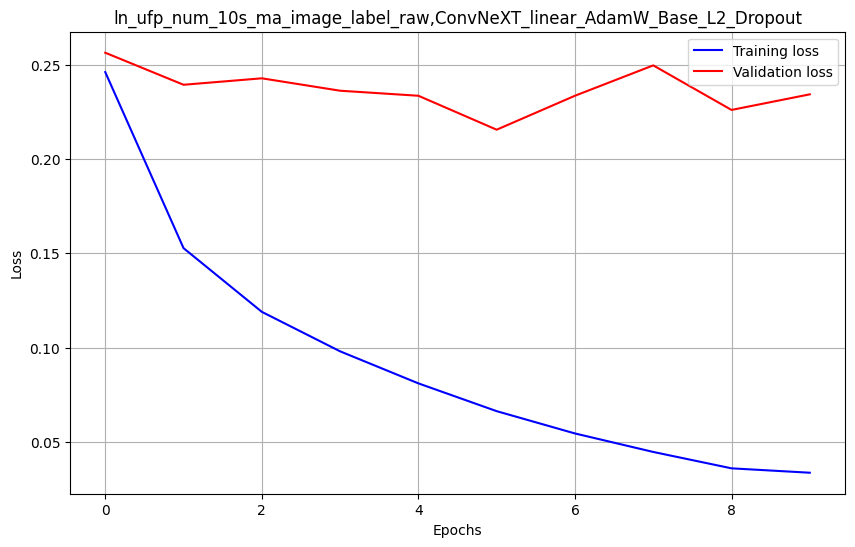

In [24]:
import matplotlib.pyplot as plt


file = 'image_path'
# file = 'audio_path'

# target = 'ln_noise_10s_ma_image_label_raw'
# target = 'ln_noise_10s_ma_spec_label_raw'   
target = 'ln_ufp_num_10s_ma_image_label_raw'
# target = 'ln_ufp_num_10s_ma_spec_label_raw'   
# target = 'ln_ufp_size_10s_ma_image_label_raw'  
# target = 'ln_ufp_size_10s_ma_spec_label_raw'

# data = pd.read_csv(filepath_or_buffer=f'./rishabh_model_files/logs/XGB_experiment_1/{target},{architecture},{file},{meta_data_name}_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_{global_dropout_rate}_l2_{global_l2_regularization}.csv')
data = pd.read_csv('./rishabh_model_files/logs/XGB_experiment_1/ln_ufp_size_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5_l2_0.0001.csv')

# Extract data from DataFrame
epochs = data['epoch']
train_loss = data['loss']
val_loss = data['val_loss']

# Plotting loss curves
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title(f'{target},{architecture}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Set y-axis ticks to intervals of 0.01
# plt.yticks(np.arange(min(train_loss.min(), val_loss.min()), max(train_loss.max(), val_loss.max()) + 0.1, 0.1))

# plt.legend()
# plt.grid(True)
# plt.show()

In [154]:
import os

# Define the list of file paths
file_paths = [
    'rishabh_model_files/models/XGB_experiment_1/ln_ufp_num_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf',
    'rishabh_model_files/models/XGB_experiment_1/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf',
    'rishabh_model_files/models/XGB_experiment_1/ln_ufp_size_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf',
    'rishabh_model_files/models/XGB_experiment_1/ln_ufp_size_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.tf',
    'rishabh_model_files/models/XGB_experiment_1/ln_noise_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.tf',
    'rishabh_model_files/models/XGB_experiment_1/ln_noise_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf',
    'compiled data/rishabh/XGB_experiment_1/'
]

# Iterate over the list and check if each file path exists
for file_path in file_paths:
    if os.path.exists(file_path):
        print("All files exist")
    else:
        print(f"The file path does not exist: {file_path}")

All files exist
All files exist
All files exist
All files exist
All files exist
All files exist
All files exist


In [160]:
test_metadata = pd.read_csv("compiled data/test_dataset_New_Sensor_1_Montreal_Atwater_August_2023.csv", low_memory=False)
# Drop the prediction columns if they exist
prediction_columns = [
    'ln_ufp_num_convnext_image_raw_prediction',
    'ln_ufp_num_convnext_audio_raw_prediction',
    'ln_ufp_size_convnext_image_raw_prediction',
    'ln_ufp_size_convnext_audio_raw_prediction',
    'ln_noise_convnext_image_raw_prediction',
    'ln_noise_convnext_audio_raw_prediction'
]
test_metadata = metadata.drop(columns=prediction_columns, errors='ignore')

test_metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,ufp_size_10s_ma_spec_label_quartile,ufp_size_10s_ma_image_label_quartile,image_extension,audio_extension,image_name,audio_name,pair_pm25,set_V3ext,set,vsby_nm
0,2023-08-18T15:21:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.195444,8.195444,3.929863,3.929863,3.598134,3.598134,3624.4,...,3.0,3.0,.jpg,.png,41_20230818_152129.jpg,41_20230818_152129.png,2.466333,ext_tst,trn,15.0
1,2023-08-18T16:08:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.428646,8.428646,3.765840,3.765840,4.246493,4.246493,4576.3,...,2.0,2.0,.jpg,.png,41_20230818_160829.jpg,41_20230818_160829.png,3.267000,ext_tst,trn,15.0
2,2023-08-18T16:09:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.011123,8.011123,3.845883,3.845883,4.221271,4.221271,3014.3,...,3.0,3.0,.jpg,.png,41_20230818_160929.jpg,41_20230818_160929.png,3.267000,ext_tst,trn,15.0
3,2023-08-18T16:10:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,7.911067,7.911067,3.903991,3.903991,4.217299,4.217299,2727.3,...,3.0,3.0,.jpg,.png,41_20230818_161029.jpg,41_20230818_161029.png,3.267000,ext_tst,tst,15.0
4,2023-08-18T16:11:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.138389,8.138389,3.856510,3.856510,4.164648,4.164648,3423.4,...,3.0,3.0,.jpg,.png,41_20230818_161129.jpg,41_20230818_161129.png,3.267000,ext_tst,trn,15.0
5,2023-08-18T16:12:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,7.824366,7.824366,3.931826,3.931826,4.312677,4.312677,2500.8,...,3.0,3.0,.jpg,.png,41_20230818_161229.jpg,41_20230818_161229.png,3.267000,ext_tst,trn,15.0
6,2023-08-18T16:13:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.085056,8.085056,3.797734,3.797734,4.192529,4.192529,3245.6,...,2.0,2.0,.jpg,.png,41_20230818_161329.jpg,41_20230818_161329.png,3.267000,ext_tst,trn,15.0
7,2023-08-18T16:14:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.001120,8.001120,3.848018,3.848018,4.209160,4.209160,2984.3,...,3.0,3.0,.jpg,.png,41_20230818_161429.jpg,41_20230818_161429.png,3.267000,ext_tst,trn,15.0
8,2023-08-18T16:15:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.109616,8.109616,3.817712,3.817712,4.244631,4.244631,3326.3,...,3.0,3.0,.jpg,.png,41_20230818_161529.jpg,41_20230818_161529.png,3.267000,ext_tst,val,15.0
9,2023-08-18T16:16:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.245568,8.245568,3.781914,3.781914,4.242190,4.242190,3810.7,...,2.0,2.0,.jpg,.png,41_20230818_161629.jpg,41_20230818_161629.png,3.267000,ext_tst,trn,15.0


In [168]:
import keras as K
import numpy as np
import pandas as pd

# Define the preprocessing function
architecture_preprocessing_convnext = K.applications.convnext.preprocess_input

# Define the test site
# test_site = 'your_test_site_id'  # Replace with your actual test site ID

# Define the ImageDataGenerator with preprocessing function
generator_test_convnext = K.preprocessing.image.ImageDataGenerator(preprocessing_function=architecture_preprocessing_convnext, 
                                                     horizontal_flip=False,
                                                     vertical_flip=False)

# Create the test generator for audio paths
test_generator_convnext_audio = generator_test_convnext.flow_from_dataframe(
    dataframe=test_metadata.loc[test_metadata['site_id'] == test_site].reset_index(drop=True),
    x_col='audio_path',
    class_mode=None,
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=64,
    shuffle=False
)

# Create the test generator for image paths
test_generator_convnext_image = generator_test_convnext.flow_from_dataframe(
    dataframe=test_metadata.loc[test_metadata['site_id'] == test_site].reset_index(drop=True),
    x_col='image_path',
    class_mode=None,
    target_size=(256, 256),
    color_mode='rgb',
    batch_size=64,
    shuffle=False
)

######### - Generate Predictions for Best CNN Models - ##############

# Best model for log(ufp_num) based on images: ln_ufp_num, image, convnext, raw
print("Running predictions for 'ln_ufp_num_convnext_image_raw_prediction'")
ln_ufp_num_convnext_image_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_ufp_num_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf')
test_metadata['ln_ufp_num_convnext_image_raw_prediction'] = ln_ufp_num_convnext_image_raw_model.predict(
    x=test_generator_convnext_image, 
    steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size))
)

# Best model for log(ufp_num) based on audio: ln_ufp_num, audio, convnext, raw
print("Running predictions for 'ln_ufp_num_convnext_audio_raw_prediction'")
ln_ufp_num_convnext_audio_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_ufp_num_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf')
test_metadata['ln_ufp_num_convnext_audio_raw_prediction'] = ln_ufp_num_convnext_audio_raw_model.predict(
    x=test_generator_convnext_audio, 
    steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size))
)

# Best model for log(ufp_size) based on images: ln_ufp_size, image, convnext, raw 
print("Running predictions for 'ln_ufp_size_convnext_image_raw_prediction'")
ln_ufp_size_convnext_image_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_ufp_size_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf')
test_metadata['ln_ufp_size_convnext_image_raw_prediction'] = ln_ufp_size_convnext_image_raw_model.predict(
    x=test_generator_convnext_image, 
    steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size))
)

# Best model for log(ufp_size) based on audio: ln_ufp_size, audio, convnext, raw
print("Running predictions for 'ln_ufp_size_convnext_audio_raw_prediction'")
ln_ufp_size_convnext_audio_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_ufp_size_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.tf')
test_metadata['ln_ufp_size_convnext_audio_raw_prediction'] = ln_ufp_size_convnext_audio_raw_model.predict(
    x=test_generator_convnext_audio,
    steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size))
)

# Best model for log(noise) based on images: ln_noise, image, convnext, raw
print("Running predictions for 'ln_noise_convnext_image_raw_prediction'")
ln_noise_convnext_image_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_noise_10s_ma_image_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,image_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.3.tf')
test_metadata['ln_noise_convnext_image_raw_prediction'] = ln_noise_convnext_image_raw_model.predict(
    x=test_generator_convnext_image,
    steps=int(np.ceil(test_generator_convnext_image.samples/test_generator_convnext_image.batch_size))
)

# Best model for log(noise) based on audio: ln_noise, audio, convnext, raw
print("Running predictions for 'ln_noise_convnext_audio_raw_prediction'")
ln_noise_convnext_audio_raw_model = load_model('rishabh_model_files/models/XGB_experiment_1/ln_noise_10s_ma_spec_label_raw,ConvNeXT_linear_AdamW_Base_L2_Dropout,audio_path,gp_v2_v3_Training_Only_Combined_IMAGINE_goproUFP_V2_V3_04252024_XGB_expt_1_dropout_0.5.tf')
test_metadata['ln_noise_convnext_audio_raw_prediction'] = ln_noise_convnext_audio_raw_model.predict(
    x=test_generator_convnext_audio, 
    steps=int(np.ceil(test_generator_convnext_audio.samples/test_generator_convnext_audio.batch_size))
)               

# Save dataframe with all predictions added
# metadata.to_csv(path_or_buf='compiled data/rishabh/XGB_experiment_1/XGB_experiment_1_UFP_V2_V3_04252024_predictions_added.csv', index=False)
test_metadata.to_csv(path_or_buf='compiled data/rishabh/XGB_experiment_1/test_dataset_New_Sensor_1_Montreal_Atwater_August_2023_predictions_added.csv', index=False)

Found 2277 validated image filenames.
Found 2277 validated image filenames.
Running predictions for 'ln_ufp_num_convnext_image_raw_prediction'
36/36 [==============================] - 38s 850ms/step
Running predictions for 'ln_ufp_num_convnext_audio_raw_prediction'
36/36 [==============================] - 38s 846ms/step
Running predictions for 'ln_ufp_size_convnext_image_raw_prediction'
36/36 [==============================] - 38s 852ms/step
Running predictions for 'ln_ufp_size_convnext_audio_raw_prediction'
36/36 [==============================] - 38s 851ms/step
Running predictions for 'ln_noise_convnext_image_raw_prediction'
36/36 [==============================] - 38s 855ms/step
Running predictions for 'ln_noise_convnext_audio_raw_prediction'
36/36 [==============================] - 39s 856ms/step


In [169]:
metadata = pd.read_csv("compiled data/rishabh/XGB_experiment_1/test_dataset_New_Sensor_1_Montreal_Atwater_August_2023_predictions_added.csv", low_memory=False)
# Drop the prediction columns if they exist

metadata.head(10)

,datetime,image_path,audio_path,ln_ufp_num_10s_ma_image_label_raw,ln_ufp_num_10s_ma_spec_label_raw,ln_ufp_size_10s_ma_image_label_raw,ln_ufp_size_10s_ma_spec_label_raw,ln_noise_10s_ma_image_label_raw,ln_noise_10s_ma_spec_label_raw,ufp_num_10s_ma_image_label_raw,...,pair_pm25,set_V3ext,set,vsby_nm,ln_ufp_num_convnext_image_raw_prediction,ln_ufp_num_convnext_audio_raw_prediction,ln_ufp_size_convnext_image_raw_prediction,ln_noise_convnext_image_raw_prediction,ln_noise_convnext_audio_raw_prediction,ln_ufp_size_convnext_audio_raw_prediction
0,2023-08-18T15:21:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.195444,8.195444,3.929863,3.929863,3.598134,3.598134,3624.4,...,2.466333,ext_tst,trn,15.0,9.161927,9.451607,3.594368,4.132736,4.173757,3.713062
1,2023-08-18T16:08:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.428646,8.428646,3.765840,3.765840,4.246493,4.246493,4576.3,...,3.267000,ext_tst,trn,15.0,9.271399,9.471431,3.454771,4.134654,4.197854,3.613668
2,2023-08-18T16:09:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.011123,8.011123,3.845883,3.845883,4.221271,4.221271,3014.3,...,3.267000,ext_tst,trn,15.0,8.945911,9.583478,3.668645,4.127860,4.237125,3.457496
3,2023-08-18T16:10:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,7.911067,7.911067,3.903991,3.903991,4.217299,4.217299,2727.3,...,3.267000,ext_tst,tst,15.0,9.120554,9.269789,3.586453,4.131256,4.188127,3.609952
4,2023-08-18T16:11:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.138389,8.138389,3.856510,3.856510,4.164648,4.164648,3423.4,...,3.267000,ext_tst,trn,15.0,9.011305,9.151276,3.518010,4.127377,4.221423,3.664524
5,2023-08-18T16:12:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,7.824366,7.824366,3.931826,3.931826,4.312677,4.312677,2500.8,...,3.267000,ext_tst,trn,15.0,8.992777,9.806414,3.507546,4.101619,4.233349,3.645284
6,2023-08-18T16:13:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.085056,8.085056,3.797734,3.797734,4.192529,4.192529,3245.6,...,3.267000,ext_tst,trn,15.0,9.007057,9.109872,3.665724,4.135425,4.219710,3.623952
7,2023-08-18T16:14:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.001120,8.001120,3.848018,3.848018,4.209160,4.209160,2984.3,...,3.267000,ext_tst,trn,15.0,9.051399,9.297901,3.736122,4.130091,4.261465,3.565450
8,2023-08-18T16:15:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.109616,8.109616,3.817712,3.817712,4.244631,4.244631,3326.3,...,3.267000,ext_tst,val,15.0,9.045218,9.534986,3.761118,4.140222,4.235124,3.527055
9,2023-08-18T16:16:29Z,data/version_3/New_Sensor_1_Montreal_Atwater_A...,data/version_3/New_Sensor_1_Montreal_Atwater_A...,8.245568,8.245568,3.781914,3.781914,4.242190,4.242190,3810.7,...,3.267000,ext_tst,trn,15.0,9.055474,9.640518,3.689158,4.138665,4.183026,3.489114
